# Concept Drift and Online Learning

We are using the following acronyms:

1. **Base Reference Model BRM**: . It refers to a model trained and not pruned.
1. **Lightweight Version Model LVM**: . It refers to a pruned version of the **BRM**.
1. **Online Learning OL**: mechanism to train a model iteratively considering 1 sample at a time, calling the *model.learn_one(...)* function for each sample.
1. **Typical Learning TL**: mechanism to train a model in the typical way, dividing the train set in batches and shuffling it at each epoch of the training.

In [102]:
%reload_ext autoreload
%autoreload 2
import warnings
import numpy as np
import pandas as pd
import threadpoolctl
import matplotlib as mpl
import matplotlib.pyplot as plt

from river import drift, ensemble, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, get_scorer
from intellect.model.ensembles import WrapRiverEnsemble
from intellect.model.torch.model import Mlp
from intellect.ranking import rank_metric_permutation_sklearn
from intellect.model.torch.pruning import globally_unstructured_connections_l1
from intellect.ranking import prune_search
from intellect.dataset import Dataset, ContinuouLearningAlgorithm
from intellect.io import create_dir, dump, load
from intellect.scoring import compute_metric_incremental
from intellect.inspect import set_seed

threadpoolctl.threadpool_limits(limits=2);
mpl.rcParams['figure.dpi']= 70
pd.set_option("display.max_columns", 100)

In [2]:
# Parameters

# training
TRAIN_SIZE = 0.1
TRAIN_EPOCHS = 100
EPOCS_WO_IMPROVE = TRAIN_EPOCHS

# neural network architecture
HIDDEN_UNITS = 5
HIDDEN_LAYERS = 5
DROPOUT = 0.1
BATCH_NORM = False

# ranking
RANK_ALGORITHM = "rank_perturbation_captum"
SUBSET_FEATURES_RATIO = 0.5

# eval metrics
METRIC_NAME = "accuracy"
INCREMENTAL_METRIC_NAME = "Accuracy"

#dataset
LABEL = "Labelb"
DATASET="../../datasets/CICIDS2017-drifts/dataset.csv"
OUTPUT_DIR = "concept_simple_output/"

In [110]:
ORIG_SCORER = get_scorer(METRIC_NAME)
SCORER = ORIG_SCORER._score_func
INCREMENTAL_SCORER = getattr(metrics, INCREMENTAL_METRIC_NAME)()

In [4]:
def load_ds():
    set_seed()
    df = pd.read_csv(DATASET, index_col=None)
    label = df.pop(LABEL)
    X_normalized = df.apply(
        lambda x: (x - x.min()) / (x.max() - x.min()))
    X_normalized[LABEL] = label

    X_train_normalized, X_test_normalized = train_test_split(X_normalized, train_size = TRAIN_SIZE, shuffle=False)
    train_labels = X_train_normalized.pop(LABEL)
    test_labels = X_test_normalized.pop(LABEL)
    return Dataset(data=X_train_normalized, label=train_labels, label_type=train_labels, shuffle=False), Dataset(data=X_test_normalized, label=test_labels, label_type=test_labels, shuffle=False)

train_ds, test_ds = load_ds()

Define a utility function that calls the online learning method, computes metrics before and after the online learning.

In [121]:
def wrap_train(model: Mlp, save_path: str, ds: Dataset=train_ds):
    set_seed()
    ypred, ytrue, ylabels, drifts = model.continuous_learning(ds, ContinuouLearningAlgorithm.ground_truth, epochs=1, batch_size=1, n_verbosity=1000)
    model.save(f"{save_path}_train")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = pd.DataFrame({"Accuracy": accuracy_score(ytrue, ypred), "Recall": recall_score(ytrue, ypred),
                           "Precision": precision_score(ytrue, ypred), "F1": f1_score(ytrue, ypred), "Drifts": str(drifts)}, index=["During OL Train"])
    df2 = pd.DataFrame({"Labels": ytrue, "Predictions": ypred, "Type": ylabels})
    dump(df, f"{save_path}_train_incremental.csv")
    dump(df2, f"{save_path}_train_incremental_raw.csv")
    return df, df2

def wrap_test(model: Mlp, save_path: str, ds: Dataset=test_ds, dump_csv=True):
    set_seed()
    ypred, ytrue, ylabels, drifts  = model.continuous_learning(ds, ContinuouLearningAlgorithm.ground_truth, epochs=1, batch_size=1, n_verbosity=1000)
    model.save(f"{save_path}_test")

    yp_normal = model.predict(ds.X)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = pd.DataFrame({"Accuracy": [accuracy_score(ytrue, ypred), accuracy_score(ytrue, yp_normal)], "Recall": [recall_score(ytrue, ypred), recall_score(ytrue, yp_normal)],
                           "Precision": [precision_score(ytrue, ypred), precision_score(ytrue, yp_normal)], "F1": [f1_score(ytrue, ypred), f1_score(ytrue, yp_normal)], "Drifts": [str(drifts), ""]},
                           index=["With OL", "Without OL"])
    df2 = pd.DataFrame({"Labels": ytrue, "Predictions Without OL": yp_normal, "Predictions With OL": ypred, "Type": ylabels})
    if dump_csv:
        dump(df, f"{save_path}_test_incremental.csv")
        dump(df2, f"{save_path}_test_incremental_raw.csv")
    return df, df2

def wrap_plot(path: str, path_raw: str, save_path: str):
    df = load(path, index_col=0)
    df2 = load(path_raw, index_col=0)
    m_incremental_without = compute_metric_incremental(df2["Labels"], df2["Predictions Without OL"])
    m_incremental_with = compute_metric_incremental(df2["Labels"], df2["Predictions With OL"])

    ax = pd.DataFrame(m_incremental_without).plot(legend=False, ylabel=INCREMENTAL_METRIC_NAME, xlabel="N Samples", title=f"Incremental {INCREMENTAL_METRIC_NAME}")
    pd.DataFrame(m_incremental_with).plot(ax=ax, legend=False)
    cd = np.array(df.loc["With OL", "Drifts"].split()[1:-1], dtype=float).astype("int")
    ax.scatter(x=cd, y=[m_incremental_with[i] for i in cd], c="r")
    ax.minorticks_on()
    ax.legend(["Without OL", "With OL"])
    plt.savefig(save_path)
    display(df)
    plt.show()

def wrap_prune_or_batch_test(amounts, save_name: str, name, ds=test_ds):
    if name not in ("prune", "batch"):
        raise Exception("Error")
    dff, dff2 = pd.DataFrame(), pd.DataFrame()
    for amount in amounts:
        if name == "prune":
            x = Mlp.load(save_name)
            x = globally_unstructured_connections_l1(x, amount)
        else:
            x = Mlp.load(save_name + f"_{amount}")
        df, df2  = wrap_test(x, f"{save_name}_{amount}", ds=ds, dump_csv=False)
        df[name] = df2[name] = amount
        dff, dff2 = pd.concat((dff, df)), pd.concat((dff2, df2))
    dump(dff, f"{save_name}_{name}_diff.csv")
    dump(dff2, f"{save_name}_{name}_diff_raw.csv")

def wrap_prune_or_batch_plot(save_name: str, name):
    if name not in ("prune", "batch"):
        raise Exception("Error")
    
    df: pd.DataFrame = load(f"{save_name}_{name}_diff.csv", index_col=0)
    df2: pd.DataFrame = load(f"{save_name}_{name}_diff_raw.csv", index_col=0)
    amounts = df[name].unique()
    _, axes = plt.subplots(nrows=1, ncols=len(amounts), figsize=(20,5), sharex=True, sharey=True)
    for ax, amount in zip(axes, amounts):
        m_incremental_without = compute_metric_incremental(df2[df2[name] == amount]["Labels"], df2[df2[name] == amount]["Predictions Without OL"])
        m_incremental_with = compute_metric_incremental(df2[df2[name] == amount]["Labels"], df2[df2[name] == amount]["Predictions With OL"])
        pd.DataFrame(m_incremental_without).plot(ax=ax, legend=False, ylabel=INCREMENTAL_METRIC_NAME, xlabel="N Samples", title=f"Incremental {INCREMENTAL_METRIC_NAME} Prune Ratio {amount}")
        pd.DataFrame(m_incremental_with).plot(ax=ax, legend=False)
        cd = np.array(df[df[name] == amount].loc["With OL", "Drifts"].split()[1:-1], dtype=float).astype("int")
        ax.scatter(x=cd, y=[m_incremental_with[i] for i in cd], c="r")
        ax.minorticks_on()
        ax.legend(["Without OL", "With OL"])
    plt.savefig(f"{save_name}_{name}_diff.pdf")
    display(df)
    plt.show()

def wrap_train_normal(batch_sizes):
    for batch_size in batch_sizes:
        set_seed()
        brm: Mlp = Mlp(train_ds.features, train_ds.n_classes, HIDDEN_UNITS, HIDDEN_LAYERS, batch_norm=BATCH_NORM, dropout_prob=DROPOUT, drift_detector=drift.ADWIN())
        history = brm.fit(train_ds, validation_dataset=0, batch_size=batch_size, max_epochs=TRAIN_EPOCHS, epochs_wo_improve=TRAIN_EPOCHS, metric=SCORER)
        dump(pd.DataFrame(history), OUTPUT_DIR + f"brm_tl_train_{batch_size}_history.csv")
        dump(brm, OUTPUT_DIR + f"brm_tl_train_{batch_size}.pt")

def wrap_train_normal_plot(batch_sizes, save_name:str):
    _, axes = plt.subplots(nrows=1, ncols=len(batch_sizes), figsize=(20,5), sharex=True, sharey=True)
    for ax, batch_size in zip(axes, batch_sizes):
        df = load(f"{save_name}_{batch_size}_history.csv")
        df[f"loss_train"].plot(ax=ax, legend=False)
        df[f"{SCORER.__name__}_train"].plot(ax=ax, legend=False)
        ax.minorticks_on()
        ax.set_title(batch_size)
        ax.legend([METRIC_NAME, "Loss"])
    plt.savefig(f"{save_name}_histories_diff.pdf")
    plt.show()

In [ ]:
create_dir(OUTPUT_DIR)

## Part 1 - TRAIN using Online learning and TEST in both cases the **BRM**

We leverage the **OL** algorithm for training the model against the train portion of the dataset. Each sample is learned individually and only once.

In [37]:
set_seed()
brm: Mlp = Mlp(train_ds.features, train_ds.n_classes, HIDDEN_UNITS, HIDDEN_LAYERS, batch_norm=BATCH_NORM, dropout_prob=DROPOUT, drift_detector=drift.ADWIN())
wrap_train(brm, OUTPUT_DIR + "brm_ol", ds=train_ds);

Batch 2830 Epoch 1 0.0027908445335924625: 100%|██████████| 2830/2830 [00:10<00:00, 268.36it/s] 


In [20]:
brm = Mlp.load(OUTPUT_DIR + "brm_ol_train.pt")
wrap_test(brm, OUTPUT_DIR + "brm_ol", ds=test_ds);

Batch 25473 Epoch 1 0.0011701886542141438: 100%|██████████| 25473/25473 [01:46<00:00, 239.13it/s] 


,Accuracy,Recall,Precision,F1,Drifts
With OL,0.958230,0.849212,0.901966,0.874794,[ 305. 433. 1873. 2161. 2353. 13137. 142...
Without OL,0.828171,0.000000,0.000000,0.000000,NaN


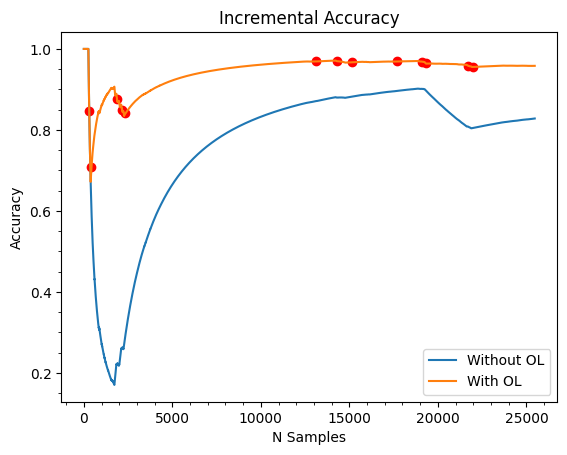

In [42]:
wrap_plot(OUTPUT_DIR + "brm_ol_test_incremental.csv",
          OUTPUT_DIR + "brm_ol_test_incremental_raw.csv",
          OUTPUT_DIR + "brm_ol_diff.pdf")

## Part 2 - Prune the model trained with the Online Learning and test the LVMs in both cases

In this experiment, we use the previously generated **BRM** trained in the Online Learning-fashion and we prune the model by different pruning amounts.

Each generated **LVM** is then tested both using Online Learning and in a normal scenario.

In [13]:
amounts = (0.1, 0.4, 0.7)
for a in prune_search(Mlp.load(OUTPUT_DIR + "brm_ol_train"), train_ds, globally_unstructured_connections_l1, amounts):
    print("Prune amount - Score - IsAboveThreshold ----->", a)

Prune amount - Score - IsAboveThreshold -----> (0.1, 0.553356890459364, True)
Prune amount - Score - IsAboveThreshold -----> (0.4, 0.553356890459364, True)
Prune amount - Score - IsAboveThreshold -----> (0.7, 0.553356890459364, True)


In [19]:
wrap_prune_or_batch_test(amounts, OUTPUT_DIR + "brm_ol_train", "prune")

Batch 25001 Epoch 1 0.011361660435795784:   0%|          | 26/25473 [02:26<39:53:21,  5.64s/it]  


,Accuracy,Recall,Precision,F1,Drifts,prune
With OL,0.958191,0.856066,0.895983,0.87557,[ 305. 433. 1873. 2033. 2289. 13137. 142...,0.1
Without OL,0.828171,0.000000,0.000000,0.00000,NaN,0.1
With OL,0.961763,0.856751,0.915304,0.88506,[ 305. 497. 1873. 2033. 2257. 2513. 131...,0.4
Without OL,0.828171,0.000000,0.000000,0.00000,NaN,0.4
With OL,0.951360,0.831620,0.878803,0.85456,[ 305. 529. 1777. 1969. 2129. 2353. 131...,0.7
Without OL,0.828171,0.000000,0.000000,0.00000,NaN,0.7


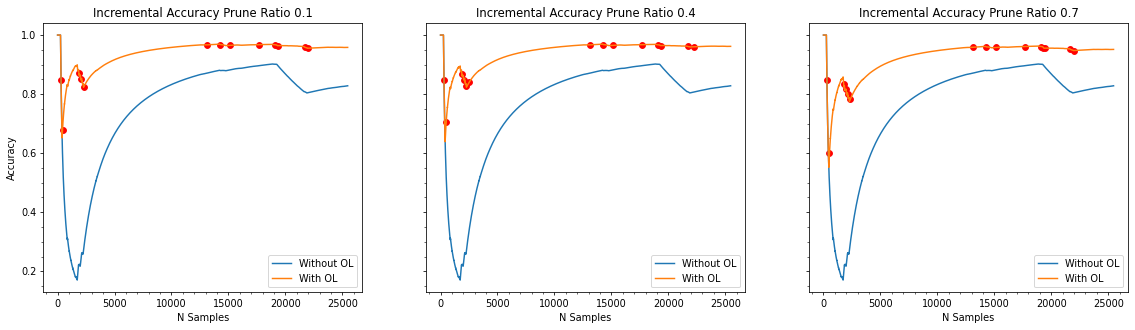

In [26]:
wrap_prune_or_batch_plot(OUTPUT_DIR + "brm_ol_train", "prune")

## Part 3 - Restart with also OL training using the pruned OL model

In [28]:
best_prune_amount = 0.4

In [29]:
brm: Mlp = globally_unstructured_connections_l1(Mlp.load(OUTPUT_DIR + "brm_ol_train"), best_prune_amount).clone(init=True)
wrap_train(brm, OUTPUT_DIR + f"lvm_ol_retrained_{best_prune_amount}", ds=train_ds);

Batch 2001 Epoch 1 0.9041190147399902: : 3000it [00:12, 236.77it/s]                         


In [30]:
brm = Mlp.load(OUTPUT_DIR + f"lvm_ol_retrained_{best_prune_amount}_train")
wrap_test(brm, OUTPUT_DIR + f"lvm_ol_retrained_{best_prune_amount}", ds=test_ds);

  0%|          | 0/25473 [00:00<?, ?it/s]

Batch 25001 Epoch 1 0.034859467297792435: : 26000it [02:22, 182.24it/s]                          


,Accuracy,Recall,Precision,F1,Drifts
With OL,0.947435,0.82705,0.861495,0.843921,[ 305. 593. 1777. 1905. 2161. 2353. 131...
Without OL,0.828171,0.00000,0.000000,0.000000,NaN


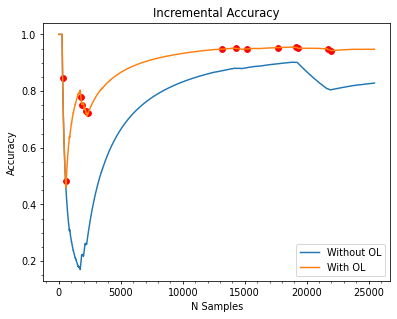

In [31]:
wrap_plot(OUTPUT_DIR + f"lvm_ol_retrained_{best_prune_amount}_test_incremental.csv",
          OUTPUT_DIR + f"lvm_ol_retrained_{best_prune_amount}_test_incremental_raw.csv",
          OUTPUT_DIR + f"lvm_ol_retrained_{best_prune_amount}_diff.pdf")

## Part 4 - Traditional TRAINING and TESTING in both cases the **BRM**

In this section, we leverage MLP models trained in the traditional way, meaning using the test set for multiple epochs of training using as an early stopping condition. Note that there is no validation set here, to be coherent with data presented in the PWPAE paper.

In addition, we want to dig whether using different values for the **BATCH_SIZE** parameter gives different results. The **batch_size** defines how many samples of data to be used at the same time for the single steps in the round of training. Generally, a higher value leads to a more generalisation of the input data and faster training phase: the neural network is able to achieve high accuracy, but it doesn't learn the small changes within data. In these cases, the fit line of the prediction with respect to the original labels follows the same trend but it doesn't have huge and immediate changes into its values. On the other hand, a small value would allow to learn more intrinsic patterns and variations in the data, which in some case can be beneficial (as in the OL with concept drifts).

We know define utility function for training a model in the traditional way (train set in batch and shuffled) with data split in batch of a given size.

In [7]:
batch_sizes = (256, 64, 16, 4)

In [10]:
wrap_train_normal(batch_sizes)

Epoch 100 {'loss_train': 0.29872871314485866, 'accuracy_score_train': 0.8816254416961131}: 100%|██████████| 100/100 [00:37<00:00,  2.67it/s]
Epoch 100 {'loss_train': 0.2643229888545142, 'accuracy_score_train': 0.8939929328621908}: 100%|██████████| 100/100 [00:56<00:00,  1.77it/s]
Epoch 100 {'loss_train': 0.2768910221839692, 'accuracy_score_train': 0.879505300353357}: 100%|██████████| 100/100 [01:54<00:00,  1.15s/it]
Epoch 100 {'loss_train': 0.15390745765544536, 'accuracy_score_train': 0.9332155477031802}: 100%|██████████| 100/100 [05:11<00:00,  3.12s/it]


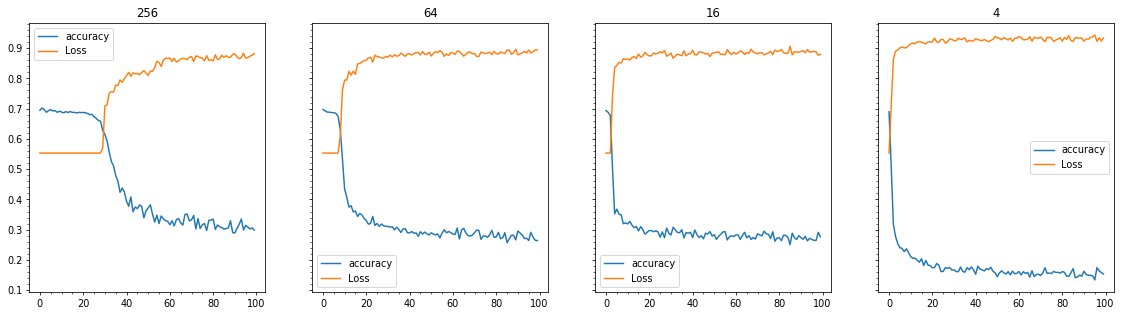

In [13]:
wrap_train_normal_plot(batch_sizes, OUTPUT_DIR + "brm_tl_train")

In [14]:
wrap_prune_or_batch_test(batch_sizes, OUTPUT_DIR + "brm_tl_train", "batch")

  0%|          | 0/25473 [00:00<?, ?it/s]

Batch 25001 Epoch 1 0.012389717623591423: : 26000it [01:42, 254.10it/s]                           
Batch 25001 Epoch 1 0.0077402666211128235: : 26000it [01:41, 255.80it/s]                          
Batch 25001 Epoch 1 0.03878753259778023: : 26000it [01:51, 233.05it/s]                           
Batch 25001 Epoch 1 0.04587330296635628: : 26000it [01:42, 252.95it/s]                           


,Accuracy,Recall,Precision,F1,Drifts,batch
With OL,0.966631,0.888965,0.914454,0.901529,[ 287. 1791. 2623. 13183. 14303. 15327. 192...,256
Without OL,0.828171,0.000000,0.000000,0.000000,NaN,256
With OL,0.965650,0.877542,0.918900,0.897745,[ 287. 1471. 1759. 1983. 2367. 13151. 143...,64
Without OL,0.828171,0.000000,0.000000,0.000000,NaN,64
With OL,0.966514,0.893534,0.909958,0.901671,[ 895. 1791. 2815. 13183. 14303. 15327. 192...,16
Without OL,0.828171,0.000000,0.000000,0.000000,NaN,16
With OL,0.964511,0.881654,0.909069,0.895152,[ 287. 1887. 2911. 13183. 14303. 15327. 192...,4
Without OL,0.828171,0.000000,0.000000,0.000000,NaN,4


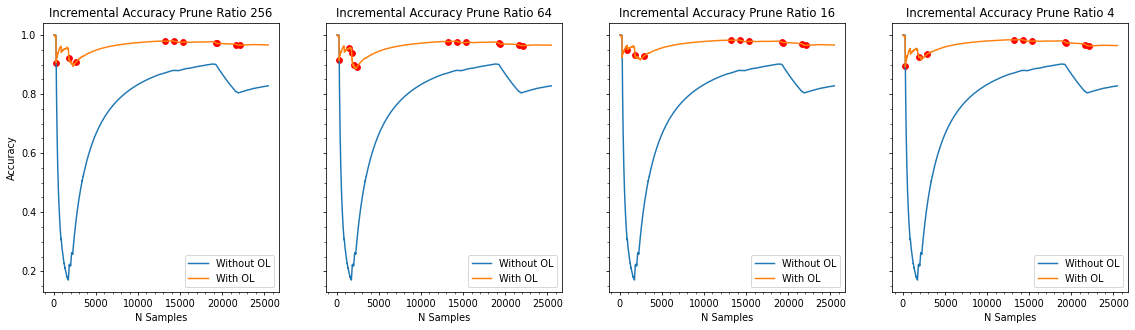

In [15]:
wrap_prune_or_batch_plot(OUTPUT_DIR + "brm_tl_train", "batch")

## Part 5 - Pruning the **BRM** traditionally trained and testing the **LVMs** in both cases

We take as a reference the **BRM** traditionally trained with Batch_size=64, as it is one of the most promising models achieved, and try to prune it by different ratio.

In [16]:
best_batch_size = 16
amounts = (0.1, 0.4, 0.7)

In [17]:
for a in prune_search(Mlp.load(OUTPUT_DIR + f"brm_tl_train_{best_batch_size}"), train_ds, globally_unstructured_connections_l1, amounts):
    print("Prune amount - Score - IsAboveThreshold ----->", a)

Prune amount - Score - IsAboveThreshold -----> (0.1, 0.9791519434628976, True)
Prune amount - Score - IsAboveThreshold -----> (0.4, 0.9614840989399294, True)
Prune amount - Score - IsAboveThreshold -----> (0.7, 0.896113074204947, True)


In [18]:
wrap_prune_or_batch_test(amounts, OUTPUT_DIR + f"brm_tl_train_{best_batch_size}", "prune")

  0%|          | 0/25473 [00:00<?, ?it/s]

Batch 25001 Epoch 1 0.042507849633693695: : 26000it [02:47, 155.64it/s]                          
Batch 25001 Epoch 1 0.03792595863342285: : 26000it [02:45, 157.34it/s]                            
Batch 25001 Epoch 1 0.024871328845620155: : 26000it [02:43, 158.80it/s]                           


,Accuracy,Recall,Precision,F1,Drifts,prune
With OL,0.965885,0.897647,0.903218,0.900424,[ 895. 1791. 2847. 13183. 14303. 15327. 192...,0.1
Without OL,0.828171,0.000000,0.000000,0.000000,NaN,0.1
With OL,0.966828,0.889422,0.915139,0.902097,[ 287. 1887. 2911. 13183. 14303. 15327. 192...,0.4
Without OL,0.828171,0.000000,0.000000,0.000000,NaN,0.4
With OL,0.963020,0.871602,0.909416,0.890107,[ 287. 1759. 1951. 2559. 13183. 14303. 153...,0.7
Without OL,0.828171,0.000000,0.000000,0.000000,NaN,0.7


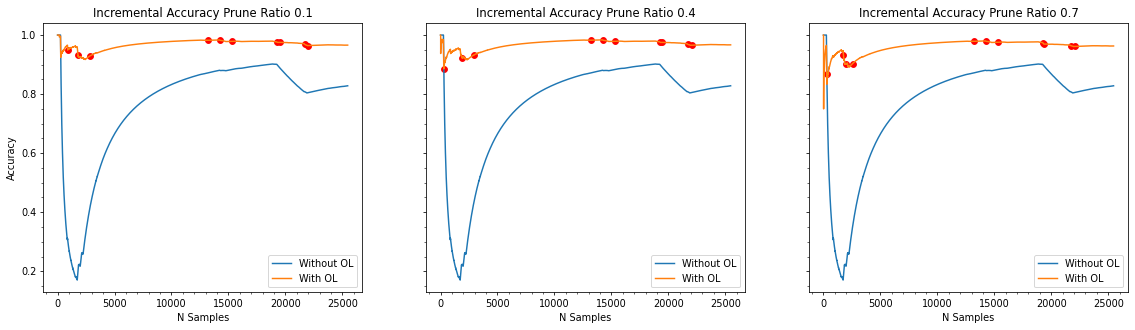

In [20]:
wrap_prune_or_batch_plot(OUTPUT_DIR + f"brm_tl_train_{best_batch_size}", "prune")

## Part 6 - Restart with traditionally training LVM and test in both cases

In [21]:
best_batch_size = 16
best_prune_amount = 0.4

In [22]:
brm: Mlp = globally_unstructured_connections_l1(Mlp.load(OUTPUT_DIR + f"brm_tl_train_{best_batch_size}"), best_prune_amount).clone(init=True)
wrap_train(brm, OUTPUT_DIR + f"lvm_tl_retrained_{best_batch_size}_{best_prune_amount}", ds=train_ds);

Batch 2001 Epoch 1 0.8848011493682861: : 3000it [00:20, 143.79it/s]                         


In [23]:
brm = Mlp.load(OUTPUT_DIR + f"lvm_tl_retrained_{best_batch_size}_{best_prune_amount}_train")
wrap_test(brm, OUTPUT_DIR + f"lvm_tl_retrained_{best_batch_size}_{best_prune_amount}", ds=test_ds);

  0%|          | 0/25473 [00:00<?, ?it/s]

Batch 25001 Epoch 1 0.04154999181628227: : 26000it [02:52, 151.04it/s]                            


,Accuracy,Recall,Precision,F1,Drifts
With OL,0.952695,0.858807,0.864933,0.861859,[ 305. 497. 1809. 1937. 2257. 2385. 131...
Without OL,0.828171,0.000000,0.000000,0.000000,NaN


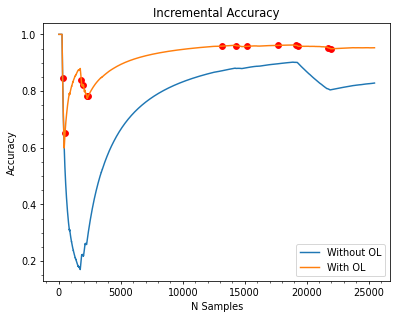

In [25]:
wrap_plot(OUTPUT_DIR + f"lvm_tl_retrained_{best_batch_size}_{best_prune_amount}_test_incremental.csv",
          OUTPUT_DIR + f"lvm_tl_retrained_{best_batch_size}_{best_prune_amount}_test_incremental_raw.csv",
          OUTPUT_DIR + f"lvm_tl_retrained_{best_batch_size}_{best_prune_amount}_diff.pdf")

## Part 7 - Ensemble with the best **BRM** and the best **LVM**

Now, run the online learning of a **LeverageBagging** and **SRPClassifier**. These algorithms leverage multiple underlying copies of the model for the training and inference of the samples.

In [103]:
from river.ensemble import LeveragingBaggingClassifier

best_batch_size = 16
best_prune_amount = 0.4

Start with a new untrained Mlp and create and ensemble of 3 models. Train using OL and then test in both ways.

In [104]:
set_seed()

x = Mlp(train_ds.features, train_ds.n_classes, HIDDEN_UNITS, HIDDEN_LAYERS, batch_norm=BATCH_NORM, dropout_prob=DROPOUT)
bag = WrapRiverEnsemble(LeveragingBaggingClassifier, model=x, n_models=3)

In [105]:
wrap_train(bag, OUTPUT_DIR + "bagging_brm", ds=train_ds);

0
1000
2000
Dumping using fallback pickle method


In [ ]:
wrap_test(bag, OUTPUT_DIR + "bagging_brm", ds=test_ds); # , drift_checker=lambda x,_,z: x.n_detected_changes != z

,Accuracy,Recall,Precision,F1,Drifts
With OL,0.972873,0.908842,0.931616,0.920088,"[0, 1, 2, 3, 1905, 2161, 2353, 14289, 14385, 1..."
Without OL,0.861736,0.195568,0.998833,0.327092,NaN


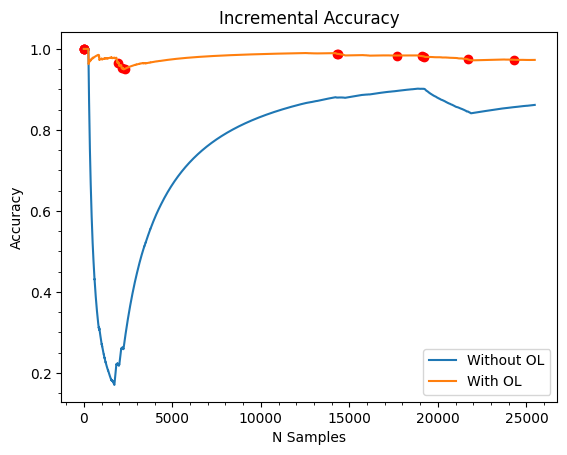

In [185]:
wrap_plot(load(OUTPUT_DIR + "bagging_brm_test_incremental.csv", index_col=0),
          load(OUTPUT_DIR + "bagging_brm_test_incremental_raw.csv", index_col=0),
          OUTPUT_DIR + "bagging_brm_diff.pdf")

Now, try with a new **LVM** with the same pruned parameters of the best one previously obtained.

In [131]:
set_seed()

x: Mlp = globally_unstructured_connections_l1(Mlp.load(OUTPUT_DIR + f"brm_tl_train_{best_batch_size}.pt"), best_prune_amount).clone(init=True)
bag = ensemble.LeveragingBaggingClassifier(model=x, n_models=3)

In [ ]:
wrap_train(bag, OUTPUT_DIR + "bagging_lvm", ds=train_ds, drift_checker=lambda x,_,z: x.n_detected_changes != z);

In [ ]:
wrap_test(bag, OUTPUT_DIR + "bagging_lvm", ds=test_ds, drift_checker=lambda x,_,z: x.n_detected_changes != z);

In [ ]:
wrap_plot(load(OUTPUT_DIR + "bagging_lvm_test_incremental.csv", index_col=0),
          load(OUTPUT_DIR + "bagging_lvm_test_incremental_raw.csv", index_col=0),
          OUTPUT_DIR + "bagging_lvm_diff.pdf")

## Part 8 - Understand feature importance when pruning

Now, we compare the feature importance between the BRM and the best LVM identified.

In [132]:
best_batch_size = 16
best_prune_amount = 0.4

In [137]:
brm_train = rank_metric_permutation_sklearn(Mlp.load(OUTPUT_DIR + f"brm_tl_train_{best_batch_size}.pt"), train_ds, metric=ORIG_SCORER)
brm_test = rank_metric_permutation_sklearn(Mlp.load(OUTPUT_DIR + f"brm_tl_train_{best_batch_size}_test.pt"), train_ds, metric=ORIG_SCORER)
lvm_train = rank_metric_permutation_sklearn(globally_unstructured_connections_l1(Mlp.load(OUTPUT_DIR + f"brm_tl_train_{best_batch_size}.pt"), best_prune_amount), train_ds, metric=ORIG_SCORER)
lvm_test = rank_metric_permutation_sklearn(globally_unstructured_connections_l1(Mlp.load(OUTPUT_DIR + f"brm_tl_train_{best_batch_size}_test.pt"), best_prune_amount), train_ds, metric=ORIG_SCORER)
df = pd.DataFrame([brm_train, lvm_train, brm_test, lvm_test], index=["BRM_Train", "LVM_Train", "BRM_Test", "LVM_TEST"]).transpose()
df.to_csv(OUTPUT_DIR + "ranking.csv")
display(df.transpose())

,Flow Duration,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Flow IAT Mean,Flow IAT Min,Fwd IAT Min,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,URG Flag Count,Down/Up Ratio,Init_Win_bytes_forward,Init_Win_bytes_backward,min_seg_size_forward
BRM_Train,0.041979,0.003958,0.034770,0.049541,0.252650,0.023463,0.045230,0.000636,0.006926,0.000071,-0.000495,0.033993,0.000353,0.035336,0.058304,0.006219,0.076254,0.000424,0.020848
LVM_Train,0.026219,-0.000919,0.026219,0.033569,0.199929,0.023958,0.007562,0.001484,0.005300,-0.000212,-0.000565,0.035053,0.000212,0.015336,0.072792,0.003887,0.065442,0.006360,0.001413
BRM_Test,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LVM_TEST,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
